In [63]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd


bins = 32
patch_g = cv2.imread("green_patch.jpg")
patch_r = cv2.imread("red_patch.jpg")
patch = np.concatenate((patch_r, patch_g), axis=1)
R = patch[:,:,2]
G = patch[:,:,1]
B = patch[:,:,0]

I = patch.sum(axis=2)
I[I == 0] = 10000
r = R / I
g = G / I
r_int = (r*(bins-1)).astype(int)
g_int = (g*(bins-1)).astype(int)

hist, _, _ = np.histogram2d(g_int.flatten(),r_int.flatten(), bins=bins, range=[[0, bins-1], [0, bins-1]])
hist_r = np.triu(hist)
hist_g = np.tril(hist)
norm, _, _ = np.histogram2d(g_int.flatten(),r_int.flatten(), bins=bins, range=[[0, bins-1], [0, bins-1]], density=True)
if np.amax(hist) > 0:
    normalized_r = hist_r/np.amax(hist_r)
    normalized_g = hist_g/np.amax(hist_g)
hist = np.flipud(normalized_g + normalized_r)

_, thresholded = cv2.threshold(normalized, 50, 255, cv2.THRESH_BINARY)

thresh1d = thresholded.flatten()

min_rgb = np.amin(patch, axis=(0,1))
max_rgb = np.amax(patch, axis=(0,1))


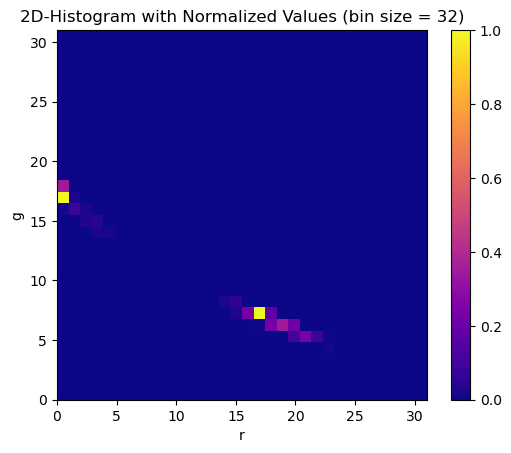

In [77]:
#plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
y_values = list(reversed(range(0, 32, 5)))
plt.imshow(hist, cmap="plasma", extent=[0,31,0,31])
plt.title("2D-Histogram with Normalized Values (bin size = 32)")
plt.xlabel("r")
plt.ylabel("g")
# change axis values to y_values
plt.colorbar()
plt.show()

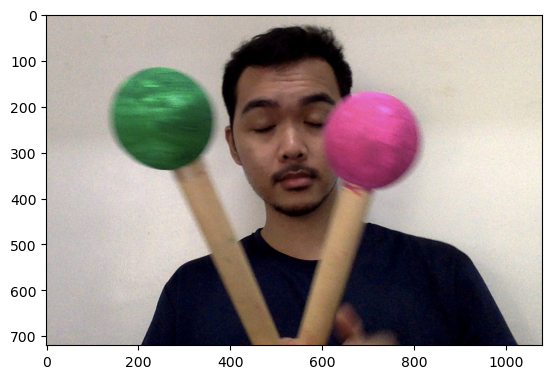

In [9]:
cap = cv2.VideoCapture("vidstream.mov")
_, frame = cap.read()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
def image_segmentation(frame):
    # RG chromaticity of frame
    np.seterr(invalid='ignore')
    I = frame.sum(axis=2)
    I[I == 0] = 100000

    frame_r = frame[:,:,2] / I
    frame_g = frame[:,:,1] / I
    
    frame_r_int = (frame_r*(bins-1)).astype(int)
    frame_g_int = (frame_g*(bins-1)).astype(int)

    back_projection_g = thresh1d[frame_g_int.flatten()*bins + frame_r_int.flatten()].reshape(frame_r.shape)
    back_projection_r = thresh1d[frame_g_int.flatten()*bins + frame_r_int.flatten()].reshape(frame_r.shape)
    
    masking = back_projection_r.astype(np.uint8)
    masked = cv2.bitwise_and(frame, frame, mask = masking)

    return masked, back_projection_g, back_projection_r, masking

In [29]:
masked, bp_g, bp_r, masking = image_segmentation(frame)

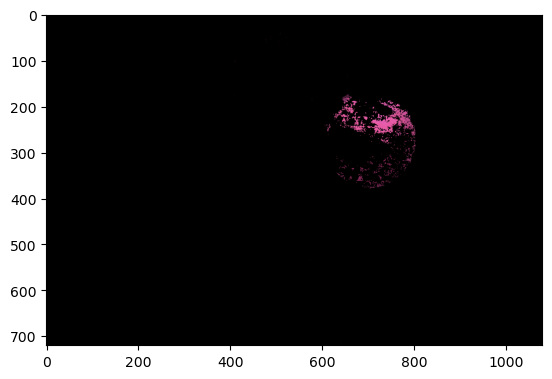

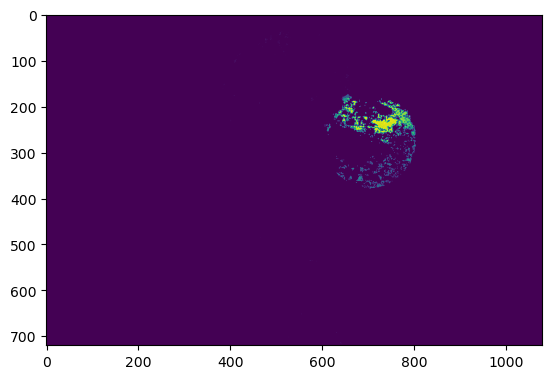

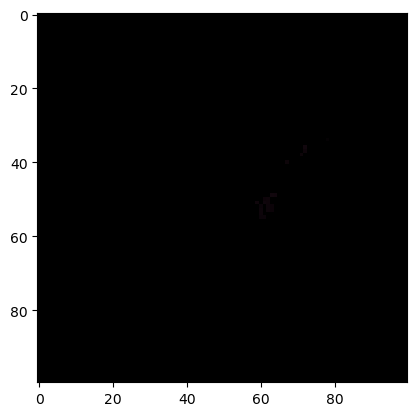

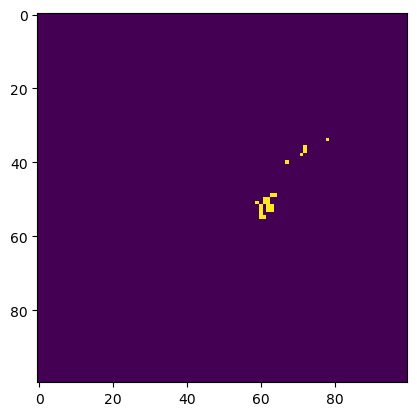

In [36]:
plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
plt.show()
slice = bp_r[50:150,350:450]
slice2 = masked[50:150,350:450,:]
slice3 = masking[50:150,350:450]
plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY))
plt.show()
plt.imshow(cv2.cvtColor(slice2, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(slice3)
plt.show()


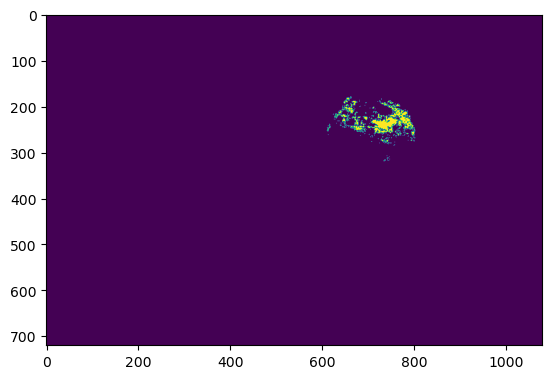

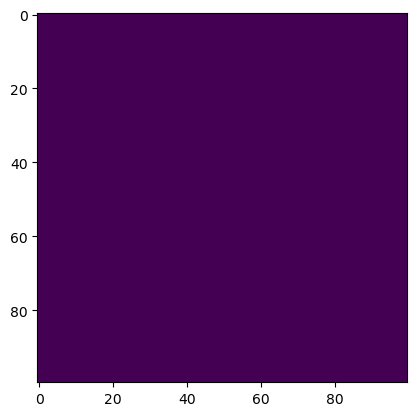

In [41]:
mask_thresh = cv2.inRange(masked, min_rgb, max_rgb)
plt.imshow(mask_thresh)
plt.show()
slice4 = mask_thresh[50:150,350:450]
plt.imshow(slice4)
plt.show()

In [22]:
a = bp_r[np.where(bp_r < 255)]
b = a[np.where(a > 0)]

In [22]:
def blob_detection(frame):
    
    center = [0,0]
    #_, thresh = cv2.threshold(frame, 30, 255, cv2.THRESH_BINARY)
    thresh = frame
    indices = np.where(thresh == 255)
    if indices[0].size > 225:
        center[0] = indices[0].mean()
        center[1] = indices[1].mean()

    center = np.array(center, dtype=np.uint16) 

    return center

In [15]:
def blob_detection2(frame):
    #plt.imshow(frame)
    #plt.show()
    _, thresh = cv2.threshold(frame, 30, 255, cv2.THRESH_BINARY)
    M = cv2.moments(thresh)

    # Calculate the centroid coordinates
    centroid_x = int(M["m10"] / M["m00"])
    centroid_y = int(M["m01"] / M["m00"])

    center = [centroid_x, centroid_y]
    
    return thresh, center

In [16]:
def downsample(frame):
        '''
        reduce resolution
        '''
        res = (427, 240)
        return cv2.resize(frame, res, interpolation = cv2.INTER_NEAREST)

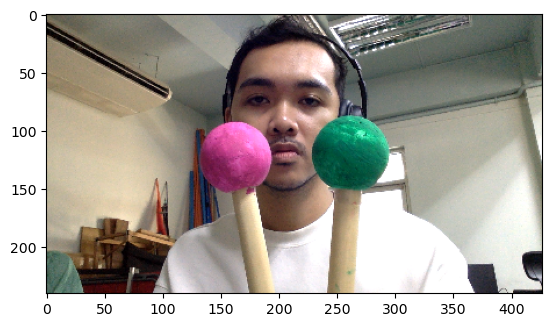

In [17]:
frame_width = 854
frame_height = 480
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, frame_width)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_height)
#create a 5 second delay to allow the camera to warm up
time.sleep(5)
_, test_frame = cam.read()
type(test_frame)
test_frame = cv2.flip(test_frame, 1)
test_frame = downsample(test_frame)
cam.release()
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
plt.show()


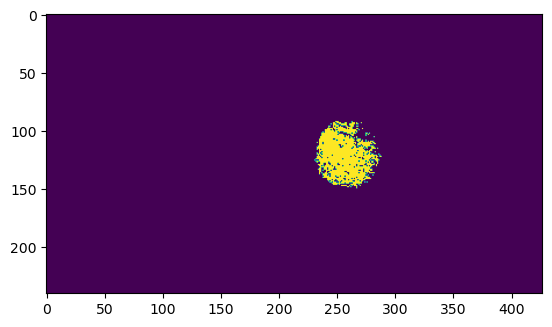

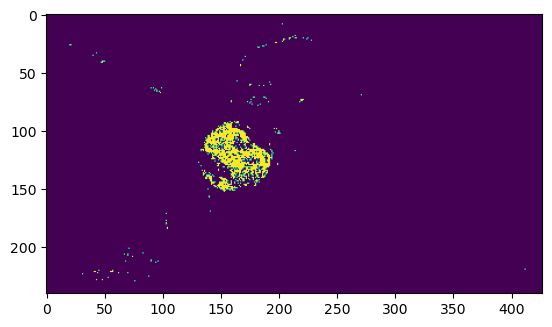

In [18]:
bp_g, bp_r = image_segmentation(test_frame)
plt.imshow(bp_g)
plt.show()
plt.imshow(bp_r)
plt.show()

Average execution time: 40.38 milliseconds
Average frame rate:  24.761810303094705
[119 161]


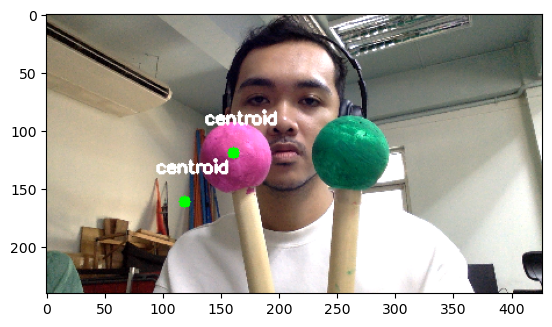

In [27]:
start = time.time()
center = blob_detection(bp_r)
# Draw a circle at the centroid coordinates on the original image
cv2.circle(test_frame, (center[1], center[0]), 5, (0, 255, 0), -1)
cv2.putText(test_frame, "centroid", (center[1] - 25, center[0] - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
end = time.time()
elapsed = end - start
print("Average execution time: {0:.2f} milliseconds".format(elapsed*1000))
print("Average frame rate: ", 1/elapsed)
print(center)

In [32]:
ind = np.where(np.logical_and(bp_r>0, bp_r<255))
print(ind)

(array([], dtype=int64), array([], dtype=int64))


In [154]:
start = time.time()
a = np.where(thresh == 255)
print(a[0].mean(), a[1].mean())
end = time.time()
elapsed = end - start
print("Average execution time: {0:.2f} milliseconds".format(elapsed*1000))

127.47119847119848 272.949494949495
Average execution time: 1.41 milliseconds


In [160]:
start = time.time()
M = cv2.moments(thresh)

# Calculate the centroid coordinates
centroid_x = int(M["m10"] / M["m00"])
centroid_y = int(M["m01"] / M["m00"])

center = [centroid_x, centroid_y]
end = time.time()
elapsed = end - start
print(center)
print("Average execution time: {0:.2f} milliseconds".format(elapsed*1000))

[272, 127]
Average execution time: 9.56 milliseconds


In [189]:
indices = np.where(bp_g == np.amax(bp_g))
print(indices[1].size)
y = indices[0].mean().astype(int)
x = indices[1].mean().astype(int)

956


Average execution time: 200.50 milliseconds
Average frame rate:  4.987430066292101


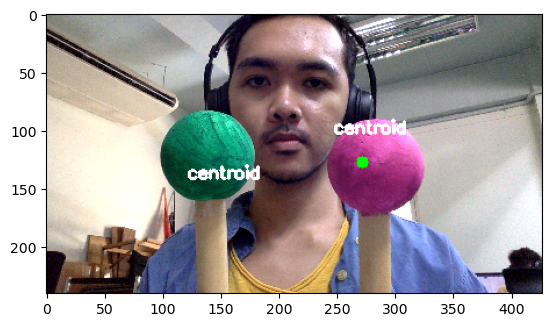

In [190]:
start = time.time()
thresh, center2 = blob_detection2(bp_r)
# Draw a circle at the centroid coordinates on the original image
cv2.circle(test_frame, (y, x), 5, (0, 255, 0), -1)
cv2.putText(test_frame, "centroid", (y, x),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
end = time.time()
elapsed = end - start
print("Average execution time: {0:.2f} milliseconds".format(elapsed*1000))
print("Average frame rate: ", 1/elapsed)

In [ ]:
img = cv2.imread('physics-experiments/opencv-logo-white.jpg', cv2.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)


In [ ]:
a = (1,2)
b = np.array((1,2), dtype=np.uint16)
print(b)